In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
import zarr

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jwave.geometry import Domain
from jax import numpy as jnp
from jwave.geometry import Medium, Sensors, TimeAxis, BLISensors
from jwave import FourierSeries
from jax import jit
from jwave.acoustics import simulate_wave_propagation

from v_system.VSystemGenerator import VSystemGenerator

In [3]:
margin = 10
N, dx = (256, 256, 128), (0.1e-3, 0.1e-3, 0.1e-3)
domain = Domain(N, dx)

c = 1500.0
medium = Medium(domain=domain, sound_speed=c, pml_size=margin)
time_axis = TimeAxis.from_medium(medium, cfl=0.3)

# sensors
num_sensors = 64
num_sensors_sqrt = jnp.sqrt(num_sensors).astype(int)
sensor_margin = margin + 20
x = jnp.linspace(sensor_margin, N[0] - sensor_margin, num_sensors_sqrt)
y = jnp.linspace(sensor_margin, N[1] - sensor_margin, num_sensors_sqrt)
z = jnp.ones(num_sensors) * (N[2] - margin)
x, y = jnp.meshgrid(x, y)

sensor_positions = (x.ravel(), y.ravel(), z)
sensors = BLISensors(positions=sensor_positions, n=N)

In [32]:
data_dir = "/home/matthew/Code/RP_data/"
if not os.path.exists(data_dir + "LNet/"):
    os.makedirs(data_dir + "LNet/")

batch_size = 3
sim = VSystemGenerator(
    n=batch_size,
    # d0_mean=2.0,
    # d0_std=.50,
    tissue_volume=[n - margin for n in N],
    output_dir=data_dir + "LNet/",
)
generation_filenames = sim.create_networks()

Storing output in /home/matthew/Code/RP_data/LNet/
Creating image 0_Lnet_i10.zarr with 10 iterations
Creating image 1_Lnet_i10.zarr with 10 iterations
Creating image 2_Lnet_i11.zarr with 11 iterations


In [7]:
# file = "Lnet_i7_0.zarr"
# path = data_dir + file

# image = jnp.array(zarr.load(path))

# from matplotlib import pyplot as plt
# plt.imshow(image[...,120])

In [51]:
@jit
def compiled_simulator(p0):
    return simulate_wave_propagation(medium, time_axis, p0=p0, sensors=sensors)


if not os.path.exists(data_dir + "p0/"):
    os.makedirs(data_dir + "p0/")

if not os.path.exists(data_dir + "pdata/"):
    os.makedirs(data_dir + "pdata/")


# image = jnp.array(zarr.load(data_dir + generation_filenames[0]))

for file in os.listdir(data_dir + "LNet/"):
    if "Lnet" in file:
        # get name of highest index folder in data_dir
        if os.listdir(data_dir + "p0/")[0] != 0:
            max_num = 0
        else:
            max_num = max(
                [
                    int(f.split("_")[1][:7])
                    for f in os.listdir(data_dir + "p0/")
                    if len(f.split("_")[1]) >= 7 
                ],
                default=0,
            )
        print(file)
        image = jnp.array(zarr.load(data_dir + "LNet/" + file))
        # image = jnp.array(zarr.load(file))
        print(image)

    p0_i = jnp.zeros(N)
    p0_i = p0_i.at[
        margin // 2 : -margin // 2,
        margin // 2 : -margin // 2,
        margin // 2 : -margin // 2,
    ].add(image)
    p0 = jnp.expand_dims(p0_i, -1)
    p0 = FourierSeries(p0_i, domain)
    zarr.save(data_dir + f"p0/{max_num}", p0_i)

    # pressure = compiled_simulator(p0)
    # pressure.shape
    # spatial_pressure = pressure.reshape(int(time_axis.Nt), int(num_sensors_sqrt), int(num_sensors_sqrt))
    # spatial_pressure = jnp.transpose(spatial_pressure, (1, 2, 0))


# p0_slice = p0.on_grid[40]
# from jwave.utils import show_field
# show_field(p0_slice, "Section of the initial pressure")

1_Lnet_i10.zarr
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


TypeError: _astype() got an unexpected keyword argument 'order'

# Visualise setup

In [18]:
from vedo import Volume, show
import vedo
import vedo.plotter # https://vedo.embl.es/docs/vedo/plotter.html#Plotter
vedo.settings.default_backend='vtk'
plotter = vedo.Plotter(axes=6, bg='white', size=(1600,800))

p0_vol = Volume(p0_i)
# vol = Volume(image)
sensor_points = vedo.Points(jnp.c_[x.ravel(), y.ravel(), z.ravel()], r=10, c="green")

# 3D pressure data plot -----------------
from vedo import Volume, Cube, Glyph, show

# TODO understand the FourierSeries discretization used in jaxdf https://ucl-bug.github.io/jaxdf/notebooks/quickstart.html#automatic-differentiation-with-jaxdf
# TODO understand the method of interpolation https://ucl-bug.github.io/jwave/notebooks/prerequisites.html#fields
# -------------------------------------------
#permute axes
sensor_width =  int(sensor_positions[0][-1] - sensor_positions[0][0])
sensor_height = int(sensor_positions[1][-1] - sensor_positions[1][0])
pcloud = Volume(spatial_pressure, dims=[sensor_width,sensor_height, 100] )
spatial_pressure_vol = Volume(spatial_pressure)
spatial_pressure_vol.cmap(['white','b','g','r']).mode(1)
spatial_pressure_vol.add_scalarbar()

plotter.show(sensor_points, spatial_pressure_vol, p0_vol)

# Add noise

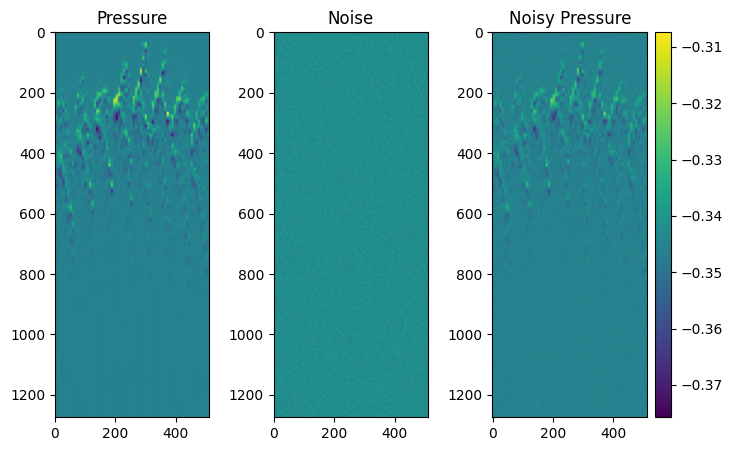

In [111]:
def add_gaussian_noise(data, noise_std_dev, key):
    noise = jax.random.normal(key, shape=data.shape, dtype=data.dtype) * noise_std_dev
    return data + noise

def add_poisson_noise(data, key):
    # JAX's Poisson random function expects 'lam' (rate) parameters to be floats
    noisy_data = jax.random.poisson(key, data, shape=data.shape)
    return noisy_data

key = jax.random.PRNGKey(seed=0)  
noise_std_dev = 0.05  # Standard deviation of the Gaussian noise
key, subkey = jax.random.split(key)  # Split the key for reuse
noisy_pressure = add_gaussian_noise(pressure, noise_std_dev, subkey)
# noisy_pressure_data = add_poisson_noise(pressure_data, subkey)
# noisy_pressure_data
fig, ax = plt.subplots(1, 3, figsize=(8,5))
ax[0].set_title("Pressure")
ax[0].imshow(pressure[...,0])
ax[1].set_title("Noise")
ax[1].imshow(noisy_pressure[...,0] - pressure[...,0])
ax[2].set_title("Noisy Pressure")
ax[2].imshow(noisy_pressure[...,0])
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = 'viridis'
bounds = [a.get_position().bounds for a in ax]
# Calculate left, bottom, width, height
left = bounds[-1][0] + bounds[-1][2] + 0.01  # Just right of the last subplot + small gap
bottom = bounds[0][1]
width = 0.02
height = bounds[0][3]

# Create an axes for the colorbar
cbar_ax = fig.add_axes([left, bottom, width, height])

# Create a colorbar in the specified axes
fig.colorbar(ScalarMappable(norm=Normalize(vmin=jnp.min(noisy_pressure), vmax=jnp.min(noisy_pressure)), cmap=cmap), cax=cbar_ax)

# Adjust the main figure layout to make room for the colorbar
# fig.subplots_adjust(right=0.9)

# Reconstruction

noisy_pressure -> U-Net -> denoised_pressure

denoised_pressure -> NN -> reconstructed_pressure

In [52]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
import math


class PATDataset(Dataset):
    def __init__(self, pressure_data, sensor_positions, N):
        """
        :param pressure_data: Numpy array of shape [time, sensors], where time is 1275 and sensors is 64.
        :param sensor_positions: Tuple of (x, y, z) positions.
        :param N: Tuple of (Nx, Ny, Nz) representing the dimensions of the volume.
        """
        self.pressure_data = pressure_data
        self.sensor_positions = sensor_positions
        self.N = N

        # Reshape the pressure data to fit the spatial dimensions
        self.spatial_data = self.reshape_to_spatial()

    def __len__(self):
        return self.pressure_data.shape[1]  # Number of sensors

    def __getitem__(self, idx):
        # Return the reshaped pressure data corresponding to all time points for a single sensor
        return self.spatial_data[:, :, idx]

    def reshape_to_spatial(self):
        # Reshape pressure data to match sensor spatial positions
        spatial_data = np.zeros((self.N[2], self.N[1], self.N[0]))

        for i, (x, y, z) in enumerate(zip(*self.sensor_positions)):
            # Place each sensor's time series data into the corresponding spatial position
            xi = int(np.round((x - sensor_margin) / (self.N[0] - 2 * sensor_margin) * (self.N[0] - 1)))
            yi = int(np.round((y - sensor_margin) / (self.N[1] - 2 * sensor_margin) * (self.N[1] - 1)))
            zi = int(z)  # Assuming z is already an integer appropriate for indexing
            spatial_data[zi, yi, xi] = self.pressure_data[:, i]

        return spatial_data
# Assume pressure_data is loaded and in shape [1275, 64], sensor_positions are computed
sensor_margin = 10  # Example margin
N = (64, 64, 10)  # Example spatial dimensions (x, y, z)
dataset = PATDataset(pressure_data, sensor_positions, N)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # Batch size and shuffle as needed
import torch.nn as nn

class PATNet(nn.Module):
    def __init__(self):
        super(PATNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2),
            nn.Conv3d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose3d(32, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose3d(16, 1, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def train_model(model, dataloader, epochs, device, max_intensity):
    # Loss function
    criterion = nn.MSELoss()
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data in dataloader:
            inputs = data['input'].to(device)  # Ensure your dataloader passes this key
            targets = data['target'].to(device)  # Ensure your dataloader passes this key

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)

        # Evaluate using PSNR
        model.eval()
        total_psnr = 0
        with torch.no_grad():
            for data in dataloader:
                inputs = data['input'].to(device)
                targets = data['target'].to(device)
                outputs = model(inputs)
                mse = criterion(outputs, targets).item()
                psnr = 20 * math.log10(max_intensity / math.sqrt(mse))
                total_psnr += psnr

        avg_psnr = total_psnr / len(dataloader)
        print(f'Epoch {epoch+1}: Avg. Loss: {avg_loss:.4f}, Avg. PSNR: {avg_psnr:.2f} dB')

# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
max_intensity = 1.0  # Adjust according to the maximum value in your dataset
model = PATNet()
dataloader = DataLoader(PATDataset(), batch_size=1, shuffle=True)  # Adjust accordingly
train_model(model, dataloader, epochs, device, max_intensity)


NameError: name 'pressure_data' is not defined

# Interpolation
Train a neural network to interpolate and denoise. 

Implicit neural representation. 